In [1]:
import pytest
import torch
from e3nn.o3 import Irreps
from e3nn import o3
from e3nn.nn import BatchNorm
import math
from utils import np_loader, rotate_sparse_tensor, test_equivariance
from sparse_voxel_model import EquivModel
# TODO: put rotate and test and np loader in equiv_utils
import MinkowskiEngine as ME
from MinkowskiEngine import SparseTensor
import torch.nn as nn
import numpy as np
%load_ext autoreload

/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
rotations = [
    (0.0, 0.0, 0.0),
    (0.0, 0.0, math.pi / 2),
    (0.0, 0.0, math.pi),
    (0.0, math.pi / 2, 0.0),
    (0.0, math.pi / 2, math.pi / 2),
    (0.0, math.pi / 2, math.pi),
    (0.0, math.pi, 0.0),
    (math.pi / 2, 0.0, 0.0),
    (math.pi / 2, 0.0, math.pi / 2),
    (math.pi / 2, 0.0, math.pi),
    (math.pi / 2, math.pi / 2, 0.0),
]

In [5]:
irreps_in = Irreps("0e")  # Single Scalar
irreps_out = Irreps("5x0e")  # 5 labels
irreps_out = Irreps("0e")  # TODO: remove
epochs = 2000
segment = True

data_directory = "../../../PilarData/Train/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Selected data to test overfitting
file_locations = [data_directory + "Electron/000005.npy",
                  data_directory + "Muon/000001.npy",
                  data_directory + "Gamma/000004.npy",
                  data_directory + "Proton/000007.npy",
                  data_directory + "Pion/000001.npy",
                  data_directory + "Electron/000007.npy",
                  data_directory + "Muon/000005.npy",
                  data_directory + "Gamma/000008.npy",
                  ]


In [6]:
true_labels = [0, 1, 2, 3, 4, 0, 1, 2]

data = []
weights = torch.zeros(5)

for i, file in enumerate(file_locations):
    sample = np_loader(file)
    coords = torch.from_numpy(sample[:, :-1]).float()
    feat = torch.from_numpy(sample[:, -1]).unsqueeze(dim=-1).float()
    feat = torch.sqrt(feat)
    label = torch.Tensor([true_labels[i]]).int()
    # center coords where mean is at origin but floor the means
    coords -= coords.mean(dim=0).floor()
    if segment:
        labels = label * torch.ones_like(feat).int()
        data.append((coords, feat, labels))
        weights[int(label)] += len(sample)
    else:
        data.append((coords, feat, label))
        weights[int(label)] += 1

weights = torch.Tensor(weights)

weights = 1 - weights / weights.sum()

print(weights)

collate = ME.utils.batch_sparse_collate
collated_data = collate(data)

coords, feats, labels = collated_data

print(f"collated_data: {collated_data=}")

print(f"{labels=}")

print(f"coords: {coords.shape}, feat: {feats.shape}")

labels = labels.long().to(device)

if segment:
    labels = labels.squeeze(1)

x1 = ME.SparseTensor(
    coordinates=coords,
    features=feats,
    device=device
)

tensor([0.6150, 0.8150, 0.6534, 0.9566, 0.9600])
collated_data: collated_data=(tensor([[   0,  -70,  -71, -124],
        [   0,  -71,  -85, -122],
        [   0,  -72,  -85, -121],
        ...,
        [   7,  -15,    6,   31],
        [   7,  -15,    5,   32],
        [   7,   34,    1,   47]], dtype=torch.int32), tensor([[0.1182],
        [0.1095],
        [0.1055],
        ...,
        [0.1231],
        [0.1231],
        [0.1462]]), tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]], dtype=torch.int32))
labels=tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]], dtype=torch.int32)
coords: torch.Size([17715, 4]), feat: torch.Size([17715, 1])


In [7]:
def test_equivariance(input, model, rotations, irreps_in, irreps_out, mode="max", device=torch.device("cpu")):
    """Test equivariance of a model
    Args:
        input (torch.Tensor): input tensor
        model (torch.nn.Module): model
        rotations (list): list of rotations
    """
    print("Testing equivariance:")
    print(f"Rotation i error: {mode}(abs(y - y_rotated))/max(abs(y)) < 1e-6")
    for i, abc in enumerate(rotations):
        abc = torch.tensor(abc)
        model = model.to(device)

        # (assert round false to avoid error)
        x2 = rotate_sparse_tensor(input, irreps_in, abc, device)  # rotate input
        y2 = model(x2)

        x1 = model(input)
        y1 = rotate_sparse_tensor(x1, irreps_out, abc, device)
        
        # y1n = torch.hstack((y1.C[:,1:], y1.F/y1.F.abs().max()))
        # y2n = torch.hstack((y2.C[:,1:], y2.F/y2.F.abs().max()))
        
        # print difference between coordinates and input
        #print(torch.hstack((x1.C[:,1:], x2.C[:,1:], (x1.C[:,1:]-x2.C[:,1:]))).cpu().numpy())
        
        #print(y1.shape, y2.shape)
        
        #y1nn, y2nn = match_coordinates(y1n.cpu(), y2n.cpu())
        
        
        #there = torch.all(y1nn[:,0:3] == y2nn[:,0:3], dim=1).reshape(-1,1)
        
        
        #print(torch.hstack((there, y2nn[:,0:3], (y1nn[:,3:] - y2nn[:,3:]))).cpu().numpy())

        diff = (y1 - y2).F.abs()
                
        if mode == "max":
            diff = diff.max()
        elif mode == "mean":
            diff = diff.mean()
        else:
            raise ValueError(f"Unknown mode {mode}")
        diff = diff/ y1.F.abs().max()
        
        
        relative_max = 1e-6 #* y1.F.abs().max()

        if diff <= relative_max:
            print(f"Rotation {i} error: {diff:.2e} < {relative_max:.2e}")
        else:
            print(f"FAILED: Rotation {i} error: {diff:.2e} > {relative_max:.2e}")

In [8]:
def match_coordinates(A, B):
    # Convert A and B into dictionaries
    dict_A = {(a[0].item(), a[1].item(), a[2].item()): a[3:] for a in A}
    dict_B = {(b[0].item(), b[1].item(), b[2].item()): b[3:] for b in B}

    # Get all unique keys from both dictionaries
    keys = set(list(dict_A.keys()) + list(dict_B.keys()))

    # Initialize the resulting arrays
    matched_A = []
    matched_B = []

    # For each unique key, look up its feature in both dictionaries
    for key in keys:
        if key in dict_A:
            feature_A = dict_A[key]
            coord = key
        else:
            feature_A = torch.tensor([0])
            coord = (0, 0, 0)

        if key in dict_B:
            feature_B = dict_B[key]
        else:
            feature_B = torch.tensor([0])
            coord = (0, 0, 0)

        # Add the key and its feature to the resulting arrays
        matched_A.append(torch.cat((torch.tensor(coord), feature_A)))
        matched_B.append(torch.cat((torch.tensor(coord), feature_B)))

    # Convert the resulting lists back into tensors
    matched_A = torch.stack(matched_A)
    matched_B = torch.stack(matched_B)

    return matched_A, matched_B

In [9]:
def rotate_sparse_tensor(x, irreps, abc, device, assert_round=False):
    """Perform a rotation of angles abc to a sparse tensor"""

    coordinates = x.C[:, 1:].to(x.F.dtype).to(device)
    coordinates = torch.einsum("ij,bj->bi", Irreps("1e").D_from_angles(*abc).to(device), coordinates)
    # D_from_angles is YXY rotation applied right to left

    if assert_round:
        assert (coordinates - coordinates.round()).abs().max() < 1e-3
    coordinates = coordinates.round().to(torch.int32)
    coordinates = torch.cat([x.C[:, :1], coordinates], dim=1)

    # rotate the features (according to `irreps`)
    features = x.F.to(device)
    features = torch.einsum("ij,bj->bi", irreps.D_from_angles(*abc).to(device), features)

    return SparseTensor(coordinates=coordinates, features=features, coordinate_manager=x.coordinate_manager)

In [8]:
model = EquivModel(irreps_in, irreps_out, segment=segment).to(device)

test_equivariance(x1, model, rotations, irreps_in, irreps_out, device=device)

model.to(device)

loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))

optim = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-2)

losses = np.zeros(epochs)
accuracies = np.zeros((epochs, 5))

KeyboardInterrupt: 

In [10]:
reduction_size = 3
AvgPool = ME.MinkowskiAvgPooling(kernel_size=reduction_size, stride=reduction_size, dimension=3)
MaxPool = ME.MinkowskiMaxPooling(kernel_size=reduction_size, stride=reduction_size, dimension=3)

In [11]:
model = MaxPool.to(device)

In [12]:
np.set_printoptions(threshold=np.inf)

In [13]:
rotations = [(0,0,0)]

In [14]:
test_equivariance(x1, model, rotations, irreps_in, irreps_out, mode="mean", device=device)

Testing equivariance:
Rotation i error: mean(abs(y - y_rotated))/max(abs(y)) < 1e-6
Rotation 0 error: 0.00e+00 < 1.00e-06


In [18]:
def max_pool3d_minkowski(input, irreps, kernel_size, stride, dim):

    assert input.F.shape[1] == irreps.dim, "Shape mismatch"
    cat_list = []

    start = 0
    max_pool = ME.MinkowskiMaxPooling(kernel_size=kernel_size, stride=stride, dimension=dim)
    for i in irreps.ls:

        end = start + 2*i+1
        temp = input.F[:,start:end,...]
        if i == 0:
            cat_list.append(temp)
        else:
            # stack the features and their norms together
            norm = temp.norm(dim=1, keepdim=True)
            cat_list.append(norm)

        start = end

    # stack all tensors along the feature dimension
    stacked_features = torch.cat(cat_list, dim=1)

    # create a sparse tensor from the stacked features
    stacked_tensors = ME.SparseTensor(coordinates=input.C, features=stacked_features)

    # perform pooling on the stacked tensor
    pooled_tensors = max_pool(stacked_tensors)

    return pooled_tensors

In [19]:
def max_pool3d_minkowski2(input, irreps, kernel_size, stride, dim):

    assert input.F.shape[1] == irreps.dim, "Shape mismatch"
    cat_list = []

    start = 0
    max_pool = ME.MinkowskiMaxPooling(kernel_size=kernel_size, stride=stride, dimension=dim)
    for i in irreps.ls:

        end = start + 2*i+1
        temp = input.F[:,start:end,...]
        if i == 0:
            temp_tensor = ME.SparseTensor(coordinates=input.C, features=temp)
            pooled_temp = max_pool(temp_tensor)
            cat_list.append(pooled_temp.F)
            pooled_coords = pooled_temp.C
        else:
            # stack the features and their norms together
            norm = temp.norm(dim=1, keepdim=True)
            #stacked = torch.cat([temp, norm], dim=1)
            norm_tensor = ME.SparseTensor(coordinates=input.C, features=norm)
            pooled_norm = max_pool(norm_tensor)
            cat_list.append(pooled_norm.F)

        start = end

    # stack all tensors along the feature dimension
    stacked_features = torch.cat(cat_list, dim=1)

    # create a sparse tensor from the stacked features
    stacked_tensors = ME.SparseTensor(coordinates=pooled_coords, features=stacked_features)

    return stacked_tensors

In [21]:
# Test with input tensor where all features are zero
dim = 3
kernel_size = 3
stride = 3
i1 = 2
i2 = 4
irreps_out = Irreps(f"2x0e+{i1}x1o+{i2}x2e")
length = 1000

coords = torch.randint(0, 10, (length, dim+1)).to(float)  # random 3D coordinates with batch index
features = torch.zeros(length, irreps_out.dim)  # zero features
input = ME.SparseTensor(coordinates=coords, features=features)
#output = max_pool3d_minkowski(input, irreps_out, kernel_size, stride, dim)
#assert torch.all(output.F == 0), "All features should be zero"

output = max_pool3d_minkowski(input, irreps_out, kernel_size, stride, dim)
output2 = max_pool3d_minkowski2(input, irreps_out, kernel_size, stride, dim)



tensor([[2., 8., 5., 6.],
        [9., 1., 5., 7.],
        [9., 5., 7., 2.],
        [6., 0., 7., 1.],
        [1., 4., 8., 5.],
        [3., 0., 9., 9.],
        [6., 5., 4., 5.],
        [0., 0., 6., 2.],
        [3., 6., 7., 1.],
        [2., 8., 9., 5.],
        [9., 9., 3., 7.],
        [4., 4., 5., 8.],
        [7., 4., 4., 7.],
        [7., 1., 8., 4.],
        [9., 2., 7., 1.],
        [2., 1., 7., 7.],
        [2., 7., 6., 9.],
        [8., 7., 8., 4.],
        [2., 6., 3., 4.],
        [6., 3., 4., 2.],
        [4., 6., 9., 8.],
        [3., 1., 0., 7.],
        [8., 6., 0., 8.],
        [7., 9., 4., 9.],
        [1., 9., 3., 9.],
        [6., 8., 4., 3.],
        [8., 9., 8., 2.],
        [8., 7., 9., 1.],
        [5., 1., 8., 9.],
        [4., 2., 5., 7.],
        [6., 7., 1., 6.],
        [5., 9., 5., 8.],
        [7., 5., 1., 8.],
        [1., 4., 3., 3.],
        [8., 7., 9., 2.],
        [7., 3., 3., 4.],
        [0., 8., 5., 4.],
        [9., 6., 0., 3.],
        [5.,

In [32]:
import timeit
from tqdm import tqdm

dim = 3
kernel_size = 3
stride = 3
irrep1 = 100
irrep2 = 20
length = 1000

irreps_out = Irreps(f"500x0e+{irrep1}x1o+{irrep2}x2e")

# Define the range of values for i1
i1_values = range(100, 1000)  # replace this with your actual range

# Lists to store the times
f1_times = []
f2_times = []

for i1 in tqdm(i1_values):
    coords = torch.randint(0, 10, (i1, dim+1)).to(float)  # random 3D coordinates with batch index
    features = torch.zeros(i1, irreps_out.dim)  # zero features
    input = ME.SparseTensor(coordinates=coords, features=features)

    
    start_time = timeit.default_timer()
    max_pool3d_minkowski(input, irreps_out, kernel_size, stride, dim)
    end_time = timeit.default_timer()
    f1_times.append(end_time - start_time)

    start_time = timeit.default_timer()
    max_pool3d_minkowski2(input, irreps_out, kernel_size, stride, dim)
    end_time = timeit.default_timer()
    f2_times.append(end_time - start_time)

100%|█████████████████████████████████████████████████████████████████████████████████| 900/900 [01:43<00:00,  8.71it/s]


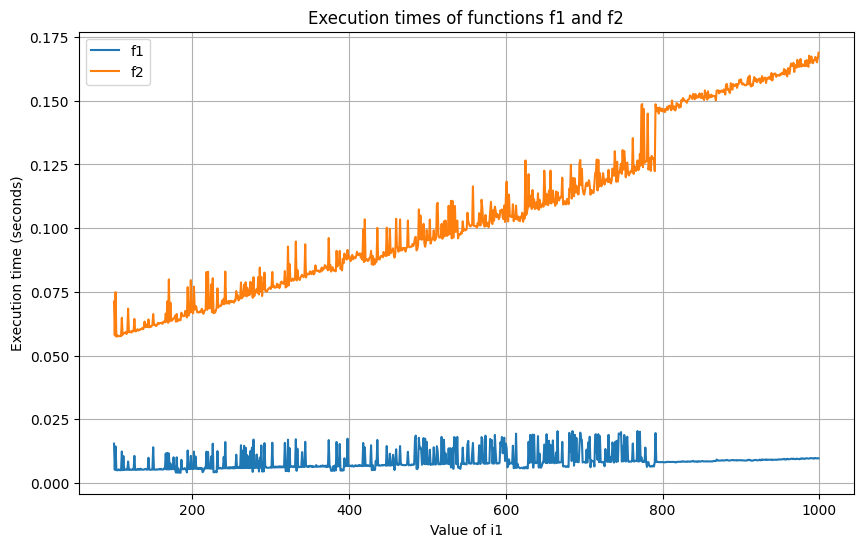

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(i1_values, f1_times, label='f1')
plt.plot(i1_values, f2_times, label='f2')
plt.xlabel('Value of i1')
plt.ylabel('Execution time (seconds)')
plt.title('Execution times of functions f1 and f2')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Test with input tensor where all features are zero
dim = 3
kernel_size = 3
stride = 3
i1 = 2
i2 = 4
irreps_out = Irreps(f"2x0e+{i1}x1o+{i2}x2e")

coords = torch.randint(0, 10, (100, dim+1)).to(float)  # random 3D coordinates with batch index
features = torch.zeros(100, irreps_out.dim)  # zero features
input = ME.SparseTensor(coordinates=coords, features=features)
output = max_pool3d_minkowski(input, irreps_out, kernel_size, stride, dim)
assert torch.all(output.F == 0), "All features should be zero"

# Test with input tensor where all features are a positive constant
features = torch.ones(100, irreps_out.dim)  # constant features
input = ME.SparseTensor(coordinates=coords, features=features)
output = max_pool3d_minkowski(input, irreps_out, kernel_size, stride, dim)
output2 = max_pool3d_minkowski2(input, irreps_out, kernel_size, stride, dim)
print(output)
print(output2)
assert torch.all(output.F == 1), "All features should be one"

# Test with an input tensor with a single non-zero feature
features = torch.zeros(100, irreps_out.dim)  # zero features
features[0, 0] = 10  # first feature is non-zero
input = ME.SparseTensor(coordinates=coords, features=features)
output = max_pool3d_minkowski(input, irreps_out, kernel_size, stride, dim)
assert torch.any(output.F == 10), "One feature should be 10"

torch.Size([98, 3])
torch.Size([98, 1])
torch.Size([98, 3])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 3])
torch.Size([98, 1])
torch.Size([98, 3])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
torch.Size([98, 5])
torch.Size([98, 1])
SparseTensor(
  coordinates=tensor([[3, 0, 3, 3],
        [5, 6, 0, 3],
        [5, 3, 3, 3],
        [1, 3, 0, 6],
        [6, 0, 0, 0],
        [6, 6, 6, 3],
        [5, 9, 0, 6],
        [1, 0, 3, 0],
        [4, 6, 0, 6],
        [8, 0, 9, 9],
        [3, 3, 3, 0],
        [6, 3, 3, 3],
        [3, 0, 0, 3],
        [6, 3, 6, 3],
        [7, 0, 6, 6],
        [8, 0, 6, 0],
        [3, 0, 0, 6],
        [8, 6, 3, 0],
        [5, 6, 6, 6],
        [0, 9, 3, 9],
        [9, 3, 3, 0],
        [6, 6, 0, 3],
        

/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/MinkowskiSparseTensor.py:295: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  warnings.warn(


AssertionError: All features should be one